In [64]:
# Современные методы вычислительной маткматики и механики, 1 семестр, 2021 г.
# Лабораторная работа 2. Методы решения бигармонических уравнений: Метод КНК.
# Решение задачи методом итераций по подобластям.
# Автор: Горынин А.Г.

import numpy as np
import scipy as sp
import math
from matplotlib import  pyplot as plt
import copy


######### Геометрические характеристики, глобальная сетка #############
X0 = 0.0; X1 = 1.0  # Левая/Правая граница
######## Параметры ячейки, локальная сетка ############ 
N_degree = 4 # степень аппроксимирующего полинома
N_colloc = N_degree+1 # количество точек коллокации
N_eq = N_colloc + 4 # Количество уравнений в локальной матрице
eps_val = 1e-12 # псевдопогрешность
# равномерное распределение точек в ячейке для мономов
y_ = np.linspace(-1., 1., N_colloc+2, endpoint = True) # локальная система координат 


# функция нагрузки 
def f(y, cell_id, Cells, GlobalNodes):
    node1 = Cells[cell_id, 0] # координата левой точки
    node2 = Cells[cell_id, 1] # координата правой точки
    h = (GlobalNodes[node2] - GlobalNodes[node1])/2
    x_c = (GlobalNodes[node2] + GlobalNodes[node1])/2
    x = y*h+x_c # переходим в глобальную систему координат

    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*math.exp(x)
    #return 1

def f_x(x):
    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*math.exp(x)
    

# Вычисление решения по найденным коэффициентам
def u(x, Matrix, Cells, GlobalNodes):
    ## переход в локальную систему
    
    h = (GlobalNodes[1] - GlobalNodes[0])/2
    
    if ( x == X0):
        cell_id = 0
    elif ( x == X1):
        cell_id = len(Cells)-1
    else:
        cell_id = int(x // (2*h)) 

    node1 = Cells[int(cell_id), 0]
    node2 = Cells[int(cell_id), 1]
    x_c = (GlobalNodes[node2] + GlobalNodes[node1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([Matrix[cell_id, i]*y**i for i in range(N_degree+1)])
    return ans

# Точное решение
def u_exact(x):
    u = x**2*(1-x)**2*math.exp(x)  
    #u = x**4/24 -x**3/(12)  + x**2/24
    return u

############################
############################
# d4u=p(x(y))  - equation
# u = a0 + a1*y + a2*y^2 + a3*y^3 + a4*y^4 + a5*y^5
# du = a1 + 2*a2*y + 3*a3*y^2 + 4*a4*y^3 + 5*a5*y^4
# d2u = 2*a2 + 6*a3*y + 12*a4*y^2 + 20*a5*y^3
# d3u = 6*a3 + 24*a4*y + 60*a5*y^2
# d4u = 24*a4 + 120*a5*y

LocalMatrix = np.zeros([N_eq, N_degree+ 1]) # матрица на ячейке
LocalVector = np.zeros( [N_eq] )  # вектор правой части на ячейку
LocalMatrix.fill(0) # заполняем матрицу нулями
LocalVector.fill(0) # заполняем вектор нулями


In [65]:
# вспомогательная функция
def positive(i):
    if (i >=0):
        return i
    else:
        return 0

# функция заполнения левой  граничной ячейки
def left_cell(Matrix):

    # граничные условия
    Matrix[0] = [y_[0]**positive(j) for j in range(N_degree+1)]
    Matrix[1] = [j*y_[0]**positive(j-1) for j in range(N_degree+1)]
    # условия согласования
    Matrix[-2] = [y_[-1]**j + j*y_[-1]**positive(j-1)  for j in range(N_degree+1)]
    Matrix[-1] = [j*(j-1)*y_[-1]**positive(j-2) + j*(j-1)*(j-2)*y_[-1]**positive(j-3)  for j in range(N_degree+1)]
    # условия коллокаций
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            Matrix[i,j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
    
# функция заполнения правой  граничной ячейки
def right_cell(Matrix):
    # граничные условия
    Matrix[-2] = [y_[-1]**positive(j) for j in range(N_degree+1)]
    Matrix[-1] = [j*y_[-1]**positive(j-1) for j in range(N_degree+1)]
    # условия согласования
    Matrix[0] = [y_[0]**j - j*y_[0]**positive(j-1)  for j in range(N_degree+1)]
    Matrix[1] = [j*(j-1)*y_[0]**positive(j-2) - j*(j-1)*(j-2)*y_[0]**positive(j-3)  for j in range(N_degree+1)]
    # условия коллокаций 
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            Matrix[i,j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
    

# функция заполнения центральной регулярной ячейки
def inner_cell(Matrix):
    # условия согласования
    Matrix[-2] = [y_[-1]**j + j*y_[-1]**positive(j-1)  for j in range(N_degree+1)]
    Matrix[-1] = [j*(j-1)*y_[-1]**positive(j-2) + j*(j-1)*(j-2)*y_[-1]**positive(j-3)  for j in range(N_degree+1)]
    # условия согласования
    Matrix[0] = [y_[0]**j - j*y_[0]**positive(j-1)  for j in range(N_degree+1)]
    Matrix[1] = [j*(j-1)*y_[0]**positive(j-2) - j*(j-1)*(j-2)*y_[0]**positive(j-3)  for j in range(N_degree+1)]
    # условия коллокаций 
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            Matrix[i,j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
    
# функция заполнения вектора правой части
def rhs(cell_id, Vector, Matrix, step, Cells, Global_Nodes):
    # проверка, какого типа ячейка
    if (cell_id == 0):
        # граничные условия
        Vector[0] = 0
        Vector[1] = 0*(step/2)
        # условия согласования
        Vector[-2] = sum([Matrix[cell_id+1, j]*(-1)**positive(j) + j*Matrix[cell_id+1, j]*(-1)**positive(j-1)  for j in range(N_degree+1)])
        Vector[-1] = sum([j*(j-1)*Matrix[cell_id+1, j]*(-1)**positive(j-2) + j*(j-1)*(j-2)*Matrix[cell_id+1, j]*(-1)**positive(j-3)  for j in range(N_degree+1)])
    elif(cell_id == len(Cells)-1):
        # условия согласования
        Vector[0] = sum([Matrix[cell_id-1, j]*(1)**positive(j) - j*Matrix[cell_id-1, j]*(1)**positive(j-1) for j in range(N_degree+1)])
        Vector[1] = sum([j*(j-1)*Matrix[cell_id-1, j]*(1)**positive(j-2) - j*(j-1)*(j-2)*Matrix[cell_id-1, j]*(1)**positive(j-3)  for j in range(N_degree+1)])
        # граничные условия
        Vector[-2] = 0
        Vector[-1] = 0*(step/2)
    else:
        # условия согласования
        Vector[0] = sum([Matrix[cell_id-1, j]*(1)**positive(j) - j*Matrix[cell_id-1, j]*(1)**positive(j-1) for j in range(N_degree+1)])
        Vector[1] = sum([j*(j-1)*Matrix[cell_id-1, j]*(1)**positive(j-2) - j*(j-1)*(j-2)*Matrix[cell_id-1, j]*(1)**positive(j-3)   for j in range(N_degree+1)])
        # условия согласования
        Vector[-2] = sum([Matrix[cell_id+1, j]*(-1)**positive(j) + j*Matrix[cell_id+1, j]*(-1)**positive(j-1)  for j in range(N_degree+1)])
        Vector[-1] = sum([j*(j-1)*Matrix[cell_id+1, j]*(-1)**positive(j-2) + j*(j-1)*(j-2)*Matrix[cell_id+1, j]*(-1)**positive(j-3)  for j in range(N_degree+1)])
    # правая часть в точках коллокации  
    Vector[2:-2] = [(step/2)**4*f(y_[i], cell_id, Cells, Global_Nodes) for i in range(1, N_colloc+1)]
    # возвращаем полученный вектор. На всякий случай копируем его.
    return copy.deepcopy(LocalVector)






In [72]:
# настройка вывода
np.set_printoptions(linewidth=300, threshold = 1e6, precision = 3)

# функция решения системы в ависимости от количества ячеек
# менять настройки внутри ячейки можно только через глобальные переменные в начале скрипта
def solve(N_elements):
    
    N_cells = N_elements  # Количество ячеек
    step = (X1-X0)/N_cells # Длина одной ячейки

    # Создаем массив узлов (границы ячеек) 
    GlobalNodes = np.linspace(X0,X1, N_cells+1, endpoint = True) 
    # Массив индексов узлов
    NodesID = np.arange(N_cells+1, dtype = int) # 
    # Массив ячеек. Каждой ячейке соответсвуют два узла на левом и на правом краю.
    Cells = np.array([ [i,i+1] for i in range(N_cells)])


    CoeffMatrix = np.zeros( [N_cells, N_degree+1] ) # матрица коэффициентов для всех ячеек
    CoeffMatrix_old = np.zeros( [N_cells, N_degree+1] ) # матрица коэффициентов для хранения

    # создаем локальную  матрицу для центральной ячейки
    inner_cell(LocalMatrix)
    A_inner = copy.deepcopy(LocalMatrix)
    LocalMatrix.fill(0)
    # создаем локальную  матрицу для левой граничной ячейки
    left_cell(LocalMatrix)
    A_left = copy.deepcopy(LocalMatrix)
    LocalMatrix.fill(0)
    # создаем локальную  матрицу для правой граничной ячейки
    right_cell(LocalMatrix)
    A_right = copy.deepcopy(LocalMatrix)
    LocalMatrix.fill(0)

    # Считаем числа обусловленности локальной и граничных матриц
    Cond_A_inner = np.linalg.cond(A_inner)
    Cond_A_left = np.linalg.cond(A_left)

    k=0
    eps = 1
    # заполняем матрицу коэффициентов начальным приближением    
    CoeffMatrix.fill(0.4)
    
    # цикл пока псевдопогрешность больше заданного значения
    while (eps > eps_val):
        # копируем матрицу коэффициентов
        CoeffMatrix_old = copy.deepcopy(CoeffMatrix)
        # обходим ячейки по порядку
        for i in range(N_cells):
            # проверка на тип ячейки
            if (i==0):
                LocalVector.fill(0)
                # обновляем вектор правой части
                F_ = rhs(i, LocalVector, CoeffMatrix, step, Cells, GlobalNodes)
                # находим коэффициенты решая задачу методом наименьших квадратов
                CoeffMatrix[i] = np.linalg.lstsq(A_left, F_, rcond = None)[0]
                #print(F_)   
            elif (i==N_cells-1):
                LocalVector.fill(0)
                F_ = rhs(i, LocalVector, CoeffMatrix, step, Cells, GlobalNodes)
                CoeffMatrix[i] = np.linalg.lstsq(A_right, F_, rcond = None)[0]
                #print(F_)
            else:
                LocalVector.fill(0)
                F_ = rhs(i, LocalVector, CoeffMatrix, step, Cells, GlobalNodes)
                CoeffMatrix[i] = np.linalg.lstsq(A_inner, F_, rcond = None)[0]
                #print(F_)
        # обновляем значения псевдопогрешности
        eps = abs(np.max(CoeffMatrix - CoeffMatrix_old))
        
        #print("Iteration: ", k, "Eps:", eps)
        k=k+1 # счетчик итераций
        #if (k>100):
        #    print("Error! Maximum number of iterations reached:", k)
        #    break
    
    print("Cells = ", N_cells, "Solution converged at Iteration: ", k, "Eps:", eps)

    # Возвращаем массив в следующей последовательности: коэффициенты, ячейки, узлы, ...
    # ...кол-во итераций, обсуловленность центральной ячейки, обусл. гр. ячейки.
    return copy.deepcopy(CoeffMatrix),  copy.deepcopy(Cells), copy.deepcopy(GlobalNodes), k, Cond_A_inner, Cond_A_left
    


In [73]:
# Отрисовка решения
def plot_solution(Solution):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    X_cor = np.arange(X0, X1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, Solution[0], Solution[1], Solution[2]) for i in X_cor])
    # значение точного решения на сетке
    u_ex = np.array([u_exact(i) for i in X_cor])
    # рисуем численное решение
    plt.plot(X_cor, u_, 'r-', label ='num')
    # рисуем точное решение
    plt.plot(X_cor, u_ex, 'b--', label = 'exact')
    plt.legend()


Cells =  5 Solution converged at Iteration:  71 Eps: 4.481970350411757e-13
Time in seconds: 0.05597996711730957
Cells =  10 Solution converged at Iteration:  231 Eps: 9.84913539614496e-13
Time in seconds: 0.3268115520477295
Cells =  20 Solution converged at Iteration:  867 Eps: 9.63742974313675e-13
Time in seconds: 2.4452931880950928
Cells =  40 Solution converged at Iteration:  3453 Eps: 9.937090213185673e-13
Time in seconds: 21.07625675201416


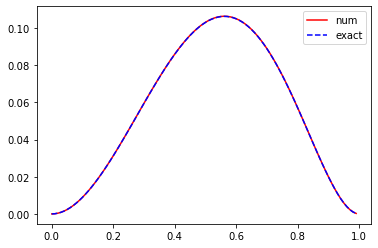

In [69]:
import time
# решаем задачу на последовательности сеток, начиная с 5

i=5
Solution_array = [  ]
error = []
X_cor = np.arange(X0, X1, 0.01)
u_ex = np.array([u_exact(i) for i in X_cor])

# засекаем время
start = time.time() 
cur_time = start       
while i < 41:
    # решаем задачу
    ans = solve(i)
    print("Time in seconds:", time.time()-cur_time)
    cur_time = time.time()
    # сохраняем решение в массив решений
    Solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(i, ans[0], ans[1], ans[2]) for i in X_cor])
    # вычисляем относительную погрешность
    error.append(np.max(abs(u_-u_ex))/np.max(abs(u_ex)))  
    i=i*2
# отрисовка последнего решения (можно поменять на любое из массива решений)
plot_solution(Solution_array[-1])

In [63]:
# импортируем утилиту для отрисовки красивых таблиц
# для установки в коммандной строке прописать: pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Mesh", "Error_relative", "Order", "Iteration", "Cond_A_inner", "Cond_A_left"]

rate = []
for i in range(len(error)-1):
    rate.append(np.log2(error[i]/error[i+1]))
    x.add_row([5*(i+1), "{:2.2e}".format(error[i]), "{:2.2e}".format(rate[i]), Solution_array[i][3], "{:2.2e}".format(Solution_array[i][4]), "{:2.2e}".format(Solution_array[i][5])])
print(x)

+------+----------------+----------+-----------+--------------+-------------+
| Mesh | Error_relative |  Order   | Iteration | Cond_A_inner | Cond_A_left |
+------+----------------+----------+-----------+--------------+-------------+
|  5   |    4.40e-02    | 2.04e+00 |     71    |   1.21e+02   |   6.98e+01  |
|  10  |    1.07e-02    | 2.01e+00 |    231    |   1.21e+02   |   6.98e+01  |
|  15  |    2.64e-03    | 2.00e+00 |    867    |   1.21e+02   |   6.98e+01  |
+------+----------------+----------+-----------+--------------+-------------+
